# Cointegration Methods
This project aims to compare 3 common techniques used for finding cointegrated pairs in pairs trading. The 3 techniques that would be compared would be [Total Least Square](#1), [Rolling Regression](#2), and [Kalman Filter](#3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from pykalman import KalmanFilter

## Cointegration Steps
In general, cointegration is to construct a linear combination of non-stationary series, such that the resulting series is (weakly) stationary.

Given a pair of stock, stock $i$ and stock $j$, with price $P_{i,t}$ and $P_{j,t}$ at time $t$ respectively, we first define the log prices $p_{k,t}=log(\frac{P_{k,t}}{P_{k,0}})$

Then we find out the cointegration/hedge ratio $\beta$ by performing regression:
$$p_{i,t}=\alpha+\beta p_{j,t}+\epsilon_t$$

And finally, we want to check whether the spread $\epsilon_t$ is stationary via the ADF test:
$$\Delta\epsilon_t=\gamma\epsilon_{t-1}+\sum_{k=1}^{p-1}{\phi_k\Delta\epsilon_{t-k}}+\varepsilon_t$$

### Set Up Test Case
To illustrate and also test the performance of the 3 methods in computing spreads, instead of using real stock price data, a test case with known true parameter values would be set up , and show how the models estimate them.

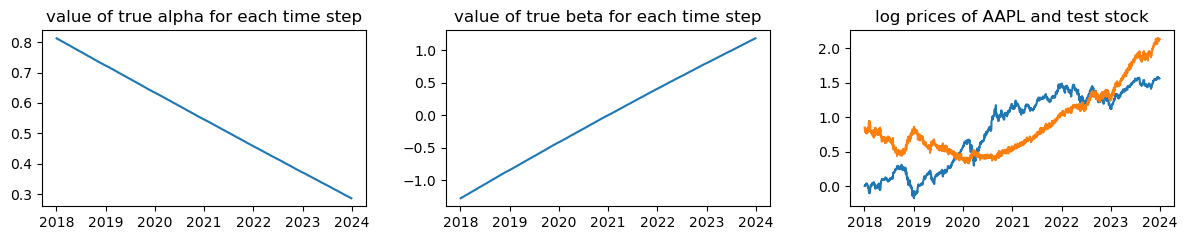

In [2]:
# load in data and compute log prices
close = pd.read_csv('close_df.csv', index_col=0, parse_dates=True)
p0 = close.apply(lambda x: next((val for val in x if pd.notnull(val)), None))
price = np.log(close.div(p0))

# set up test case
np.random.seed(0)
stock1 = 'AAPL'
s1 = price[stock1]  
data_len = len(s1)
def alpha_trend(x):  # random function to make parameters time-varying
    return x ** 2 + 3 * x - 2
def beta_trend(x):
    return -3 * x ** 2 - 5 * x + 6
alpha_true = pd.Series(alpha_trend(np.linspace(0.75, 0.63, data_len)), index=s1.index)
beta_true = pd.Series(beta_trend(np.linspace(-2.6, -2.35, data_len)), index=s1.index)
s2 = alpha_true + beta_true * s1 + np.random.normal(loc=0, scale=0.02, size=data_len)  # create test case
price['test_s1'] = s1
price['test_s2'] = s2

# plot out the true underlying paramters values
fig, axs = plt.subplots(1, 3, figsize=(12, 2.5))
axs[0].plot(alpha_true)
axs[0].set_title('value of true alpha for each time step')
axs[1].plot(beta_true)
axs[1].set_title('value of true beta for each time step')
axs[2].plot(s1)
axs[2].plot(s2)
axs[2].set_title(f'log prices of {stock1} and test stock')
plt.tight_layout()

<a name="1"></a>
## Total Least Square
One question to be asked when estimating the cointegration ratio $\beta$ is whether we should use Ordinary Least Square (OLS) or Total Least Square (TLS). In OLS, we treat $X$ as an independent variable, meaning that we account for the variance in one variable only. However, when we are running a regression using 2 stock price series, both stocks should be modelled as dependent variable, and TLS would be more suitable in this case.

To solve for TLS, the objective function $f(\alpha, \beta)$ we want to minimize is given by:
$$\min f(\alpha, \beta) = \min \frac{\sum_{t}{(p_{i,t}-\alpha-\beta p_{j,t})^2}}{(1+\beta^2)}$$

which would result in the estimator $\hat{\beta} = \frac{-c_1+\sqrt{c_1^2-4c_0c_2}}{2c_0}$ and $\hat{\alpha}=\bar{p_i}-\hat{\beta}\bar{p_j}$, \
where $c_0=-c_2=\sum_{t=1}^T(p_{i,t}-\bar{p_i})(p_{j,t}-\bar{p_j})$, $c_1=\sum_{t=1}^T(p_{i,t}-\bar{p_i})^2-(p_{j,t}-\bar{p_j})^2$

In [3]:
def simple_tls(x: pd.Series, y: pd.Series) -> tuple[float, float, pd.Series]:
    c0 = np.sum((x - x.mean()) * (y - y.mean()))
    c1 = np.sum((x - x.mean()) ** 2 - (y - y.mean()) ** 2)
    c2 = -c0
    beta1 = (-c1 + np.sqrt(c1 ** 2 - 4 * c0 * c2)) / (2 * c0)
    beta0 = y.mean() - beta1 * x.mean()
    residual = y - beta0 - beta1 * x
    return beta0, beta1, residual

In [4]:
# randomly pick 2 stocks as example
stock1, stock2 = 'test_s1', 'test_s2'
data = price[[stock1, stock2]]
data = data.dropna(how='any')

# apply simple tls calculation
tls_alpha, tls_beta, tls_spread = simple_tls(data.iloc[:, 0], data.iloc[:, 1])

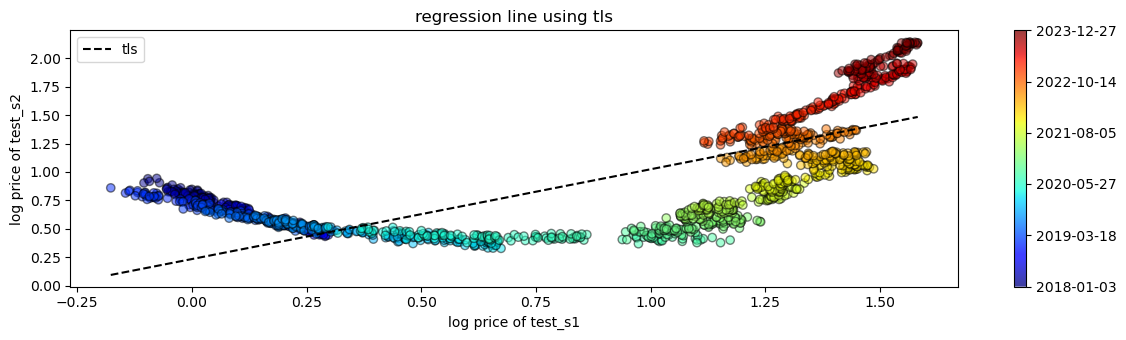

In [5]:
# plot the log prices relationship between the 2 stocks
plt.figure(figsize=(12, 3.5))
sc = plt.scatter(x=data[stock1],
                 y=data[stock2],
                 c=date2num(data.index),
                 cmap=plt.get_cmap('jet'),
                 marker='o',
                 alpha=0.5,
                 edgecolor='k')
cbar = plt.colorbar(sc)
selected_dates = data.index[::int(len(data.index) / 5)]
selected_numeric_dates = date2num(selected_dates)
cbar.set_ticks(selected_numeric_dates)
cbar.set_ticklabels([date.date() for date in selected_dates])
plt.xlabel(f'log price of {stock1}')
plt.ylabel(f'log price of {stock2}')
plt.title('regression line using tls')

# plot of the regression line calculated from tls
x = np.linspace(min(data[stock1]), max(data[stock1]), 1000)
y = tls_alpha + tls_beta * x
plt.plot(x, y, 'k--', label='tls')
plt.legend()
plt.tight_layout()

the test statistics for stationarity using tls is -0.8892819516559305


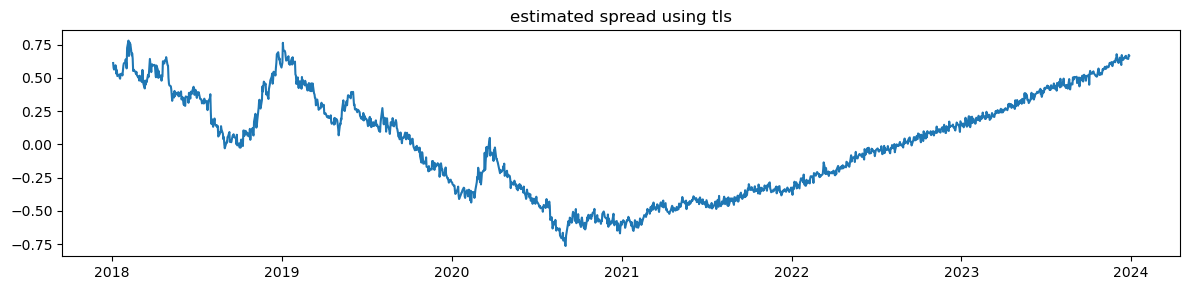

In [6]:
# adf test on the residual
plt.figure(figsize=(12, 3))
plt.plot(tls_spread)
plt.title('estimated spread using tls')
plt.tight_layout()
adf_res = adfuller(tls_spread)
t_stat = adf_res[0]
print(f'the test statistics for stationarity using tls is {t_stat}')

<a name="2"></a>
## Rolling Regression
The above simple TLS approach would assume that the intercept and slope is $\textbf{constant}$ over time, which is obviously not likely in the real world. Therefore one easy approach to estimate the time-varying intercept $\alpha_t$ and slope $\beta_t$ is by rolling regression.

In [7]:
# rolling regression calculation
rolling_window: int = 252
alpha_list = []
beta_list = []
spread_list = []
for i in range(rolling_window, len(data) + 1):
    rolling_data = data.iloc[i - rolling_window: i]
    alpha, beta, spread = simple_tls(rolling_data.iloc[:, 0], rolling_data.iloc[:, 1])
    alpha_list.append(alpha)
    beta_list.append(beta)
    spread_list.append(spread[-1])
rolling_res = pd.DataFrame(zip(alpha_list, beta_list, spread_list), 
                           columns=['rolling_alpha', 'rolling_beta', 'rolling_spread'], 
                           index=data.index[rolling_window - 1:])

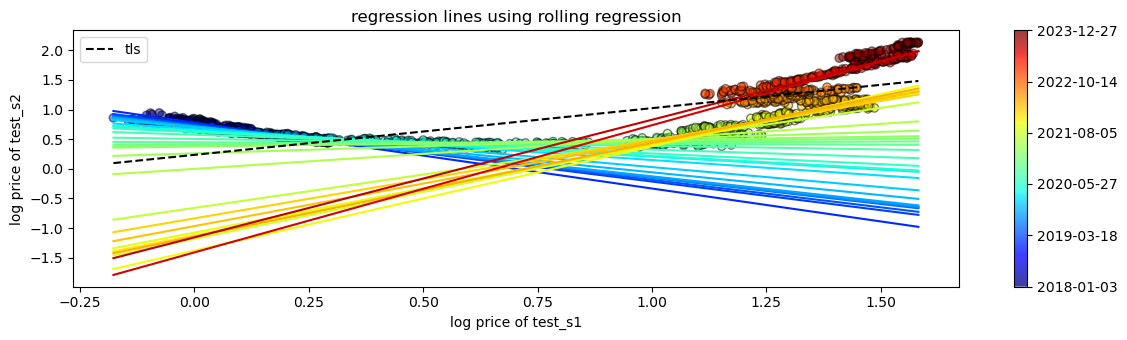

In [8]:
plt.figure(figsize=(12, 3.5))
sc = plt.scatter(x=data[stock1],
                 y=data[stock2],
                 c=date2num(data.index),
                 cmap=plt.get_cmap('jet'),
                 marker='o',
                 alpha=0.5,
                 edgecolor='k')
cbar = plt.colorbar(sc)
selected_dates = data.index[::int(len(data.index) / 5)]
selected_numeric_dates = date2num(selected_dates)
cbar.set_ticks(selected_numeric_dates)
cbar.set_ticklabels([date.date() for date in selected_dates])
plt.xlabel(f'log price of {stock1}')
plt.ylabel(f'log price of {stock2}')
plt.title('regression lines using rolling regression')

# plot of the regression lines using rolling regression
step = 30
x = np.linspace(min(data[stock1]), max(data[stock1]), len(rolling_res[::step]))
norm = plt.Normalize(date2num(data.index.min()), date2num(data.index.max()))
for i in range(len(rolling_res[::step])):
    row = rolling_res[::step].iloc[i]
    color = plt.get_cmap('jet')(norm(date2num(row.name)))
    y = row.rolling_alpha + row.rolling_beta * x
    if max(y) < 2 and min(y) > -2:
        plt.plot(x, y, c=color)

# plot of the regression line calculated from tls
x = np.linspace(min(data[stock1]), max(data[stock1]), 1000)
y = tls_alpha + tls_beta * x
plt.plot(x, y, 'k--', label='tls')
plt.legend()
plt.tight_layout()

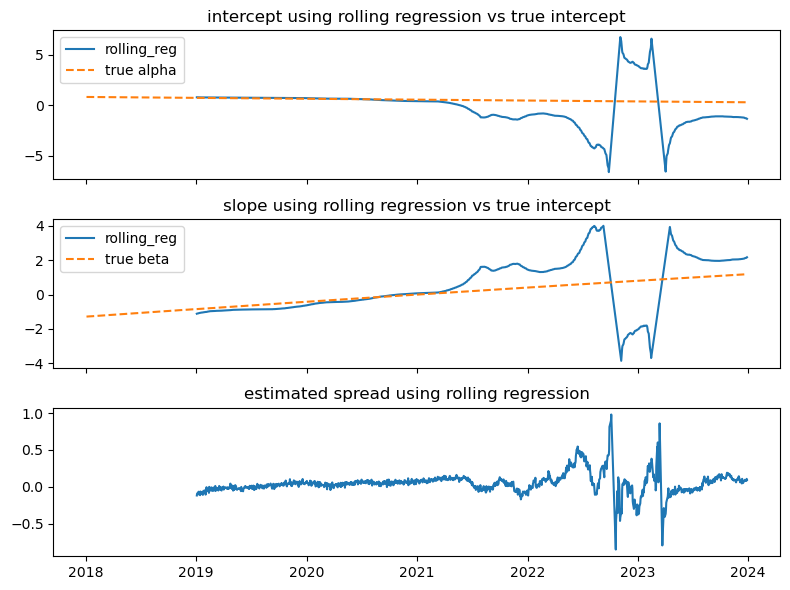

In [9]:
# plot of intercept, slope, spread
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)

# adjustment for some extreme values when plotting
plt_rolling_alpha = rolling_res[abs(rolling_res.rolling_alpha) < 7].rolling_alpha
plt_rolling_beta = rolling_res[abs(rolling_res.rolling_beta) < 4].rolling_beta
plt_rolling_spread = rolling_res[abs(rolling_res.rolling_spread) < 1].rolling_spread

axs[0].set_title('intercept using rolling regression vs true intercept')
axs[0].plot(plt_rolling_alpha, label='rolling_reg')
axs[0].plot(alpha_true, '--', label='true alpha')
axs[0].legend()
axs[1].set_title('slope using rolling regression vs true intercept')
axs[1].plot(plt_rolling_beta, label='rolling_reg')
axs[1].plot(beta_true, '--', label='true beta')
axs[1].legend()
axs[2].set_title('estimated spread using rolling regression')
axs[2].plot(plt_rolling_spread)
plt.tight_layout()

<a name="3"></a>
## Kalman Filter
Although rolling regression is able to provide a more dynamic component to the model, it is highly dependent on the arbitrary choice we choose for the rolling window, and this leads to the introduction of the kalman filter approach.

Kalman filter is useful to update our knowledge of the state variable $x_t$ recursively when a new data point comes in. Mathematically speaking, knowing the conditional distribution of $x_t$ given information up to time $t-1$ ($\mathcal{F}_{t-1}$) and new data $y_t$, we want to obtain the conditional distribution of $x_t$ given $\mathcal{F}_{t}$.

To apply kalman filter into regression to estimate the time-varying intercept $\alpha_t$ and slope $\beta_t$, we could first set up the linear state space model:
$$p_{i,t}=\alpha+\beta p_{j,t}+\epsilon_t$$
$$\alpha_{t+1}=\alpha_{t}+\varepsilon_{t+1}$$
$$\beta_{t+1}=\beta_{t}+\eta_{t+1}$$
with state errors $\begin{bmatrix}\varepsilon_t \\ \eta_t \end{bmatrix}\sim N(0, Q)$, where $Q=\begin{bmatrix}\sigma_\varepsilon^2 & 0 \\0 & \sigma_\eta^2\end{bmatrix}$,
and measurement errors $\epsilon_t \sim N(0, \sigma_\epsilon^2)$

The whole iteration of kalman filter starts with some inital state mean $\mu_0$ and initial state covariance $\Sigma_0$. Under the bayesian framework, we could just set up some non-informative prior which lead to minimum impact on the posterior. But here, I would just default a 63 initial state window to estimate the initial state mean. Some other parameters including $\Sigma_0$, $\sigma_\varepsilon$, $\sigma_\eta$ and $\sigma_\epsilon$ will be estimated using the EM algorithm.

In [10]:
# use the first initial_state_window to estimate the state mean (not necessary)
initial_state_window = 63
initial_state_data = data.iloc[:initial_state_window]
initial_mean = simple_tls(initial_state_data.iloc[:, 0], initial_state_data.iloc[:, 1])[:2]

# apply kalman filter
s1, s2 = data.iloc[:, 0], data.iloc[:, 1]
kf = KalmanFilter(
    n_dim_state=2,
    n_dim_obs=1,
    initial_state_mean=np.array(initial_mean),
    transition_matrices=np.identity(2),
    transition_offsets=np.zeros(2),
    observation_matrices=sm.add_constant(s1).values[:, np.newaxis],
    observation_offsets=0,
    em_vars=['initial_state_covariance', 'transition_covariance', 'observation_covariance']
)
state_mean, state_cov = kf.filter(s2.values)
kf_alpha, kf_beta = state_mean[:, 0], state_mean[:, 1]
kf_spread = s2.values - kf_alpha - kf_beta * s1.values
kf_res = pd.DataFrame(zip(kf_alpha, kf_beta, kf_spread), 
                      columns=['kf_alpha', 'kf_beta', 'kf_spread'], 
                      index=data.index)

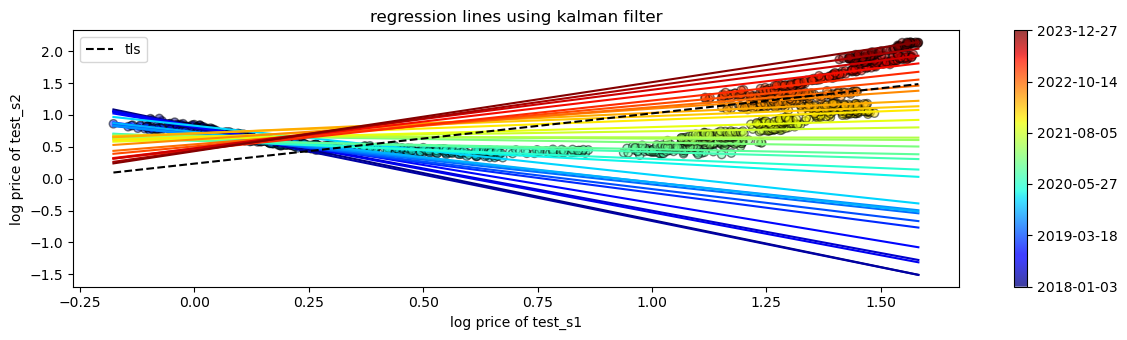

In [11]:
plt.figure(figsize=(12, 3.5))
sc = plt.scatter(x=data[stock1],
                 y=data[stock2],
                 c=date2num(data.index),
                 cmap=plt.get_cmap('jet'),
                 marker='o',
                 alpha=0.5,
                 edgecolor='k')
cbar = plt.colorbar(sc)
selected_dates = data.index[::int(len(data.index) / 5)]
selected_numeric_dates = date2num(selected_dates)
cbar.set_ticks(selected_numeric_dates)
cbar.set_ticklabels([date.date() for date in selected_dates])
plt.xlabel(f'log price of {stock1}')
plt.ylabel(f'log price of {stock2}')
plt.title(f'regression lines using kalman filter')

# plot of the regression lines using kalman filter
step = 50
x = np.linspace(min(data[stock1]), max(data[stock1]), len(kf_res[::step]))
norm = plt.Normalize(date2num(data.index.min()), date2num(data.index.max()))
for i in range(len(kf_res[::step])):
    row = kf_res[::step].iloc[i]
    color = plt.get_cmap('jet')(norm(date2num(row.name)))
    y = row.kf_alpha + row.kf_beta * x
    if max(y) < 3 and min(y) > -3:
        plt.plot(x, y, c=color)

# plot of the regression line calculated from tls
x = np.linspace(min(data[stock1]), max(data[stock1]), 1000)
y = tls_alpha + tls_beta * x
plt.plot(x, y, 'k--', label='tls')
plt.legend()
plt.tight_layout()

the test statistics for stationarity using kalman filter is -21.940548442988707


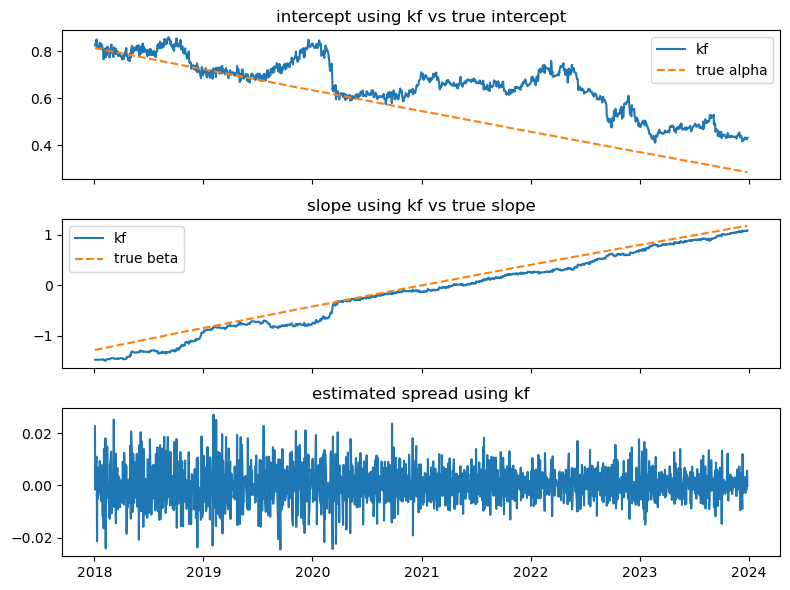

In [12]:
# plot of intercept, slope, spread when using kalman filter
fig, axs = plt.subplots(3, 1, figsize=(8, 6), sharex=True)
axs[0].set_title('intercept using kf vs true intercept')
axs[0].plot(kf_res.kf_alpha, label='kf')
axs[0].plot(alpha_true, '--', label='true alpha')
axs[0].legend()
axs[1].set_title('slope using kf vs true slope')
axs[1].plot(kf_res.kf_beta, label='kf')
axs[1].plot(beta_true, '--', label='true beta')
axs[1].legend()
axs[2].set_title('estimated spread using kf')
axs[2].plot(kf_res.kf_spread)
plt.tight_layout()

# adf test on the spread when using kalman filter
adf_res = adfuller(kf_res.kf_spread)
t_stat = adf_res[0]
print(f'the test statistics for stationarity using kalman filter is {t_stat}')

In [13]:
def compare_methods(tls_res: tuple, rolling_res: pd.DataFrame, kf_res: pd.DataFrame) -> pd.DataFrame:
    tls_alpha_mse = np.sum((alpha_true - tls_res[0]) ** 2)
    tls_beta_mse = np.sum((beta_true - tls_res[1]) ** 2)
    tls_adf_stat = adfuller(tls_res[2])[0]
    roll_reg_alpha_mse = np.sum((alpha_true - rolling_res.rolling_alpha) ** 2)
    roll_reg_beta_mse = np.sum((beta_true - rolling_res.rolling_beta) ** 2)
    roll_reg_adf_stat = adfuller(rolling_res.rolling_spread)[0]
    kf_alpha_mse = np.sum((alpha_true - kf_res.kf_alpha) ** 2)
    kf_beta_mse = np.sum((beta_true - kf_res.kf_beta) ** 2)
    kf_adf_stat = adfuller(kf_res.kf_spread)[0]
    res = {
        'tls': [tls_alpha_mse, tls_beta_mse, tls_adf_stat],
        'rolling_reg': [roll_reg_alpha_mse, roll_reg_beta_mse, roll_reg_adf_stat],
        'kf': [kf_alpha_mse, kf_beta_mse, kf_adf_stat]
    }
    res = pd.DataFrame(res, index=['alpha_mse', 'beta_mse', 'adf_stat'])
    return res

In [14]:
compare_methods((tls_alpha, tls_beta, tls_spread), rolling_res, kf_res)

,tls,rolling_reg,kf
alpha_mse,181.182910,122844.329151,27.652363
beta_mse,1741.807824,71048.897256,44.247626
adf_stat,-0.889282,-32.932914,-21.940548


The above metrics show that the kalman filter approach could estimate the true time-varying parameters much more accurately, and the high negative value of the adf t-stat implies that the model could capture a very stationary behaviour in the spread.

Finally, a visualisation tool is created to plot out the relationship of different stocks using the methods used above.